## Feature Selection - Discretization

We are going to classify pulsar candidates as pulsars and try to improve our algorithms performance by
selecting just the most important subset of features

First the necessary imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

Load our dataset. The feature names are taken from the dataset README

ie = Integrated Profile
dm = DM-SNR Curve

In [2]:
names = [
    "ie_mean",
	"ie_standard_deviation",
	"ie_excess_kurtosis",
	"ie_skewness",
	"dm_mean",
    "dm_standard_deviation",
    "dm_excess_kurtosis",
    "dm_skewness",
    "target"
]
df = pd.read_csv('HTRU_2.csv', names=names)
df.head()

,ie_mean,ie_standard_deviation,ie_excess_kurtosis,ie_skewness,dm_mean,dm_standard_deviation,dm_excess_kurtosis,dm_skewness,target
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


Lets split our dataset to train and test sets


In [3]:
x_train, x_test, y_train, y_test = train_test_split(df[["ie_mean",
                                                        "ie_standard_deviation",
                                                        "ie_excess_kurtosis",
                                                        "ie_skewness",
                                                        "dm_mean",
                                                        "dm_standard_deviation",
                                                        "dm_excess_kurtosis",
                                                        "dm_skewness",]],
                                                    df['target'],
                                                    test_size = 0.25, random_state = 0)
print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(13423, 8) (13423,) (4475, 8) (4475,)


We will define some basic utility functions. A simple evaluation function to call whenever we want to evaluate our model,
and a pretty print for better dictionary printing

In [4]:
def evaluate_model(actual, predicted, print_for_params=False, average="macro"):
    average = average
    recall_score = metrics.recall_score(actual, predicted, average=average)
    precision_score = metrics.precision_score(actual, predicted, average=average)
    f1_score = metrics.f1_score(actual, predicted, average=average)

    if print_for_params:
        average_params = ['binary', 'micro', 'macro', 'weighted']
        for param in average_params:
            recall_score = metrics.recall_score(actual, predicted, average=param)
            print(f"Precision score: {precision_score:.2f} with average parameter: {param}")

            precision_score = metrics.precision_score(actual, predicted, average=param)
            print(f"Recall score: {recall_score:.2f} with average parameter: {param}")

            f1_score = metrics.f1_score(actual, predicted, average=param)
            print(f"F1 score: {f1_score:.2f} with average parameter: {param} \n")

    accuracy_score = metrics.accuracy_score(actual, predicted)
    if print_for_params:
        print(f"Accuracy score: {accuracy_score:.2f}")

    return accuracy_score, precision_score, recall_score, f1_score

In [5]:
def pprint(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pprint(value, indent + 1)
        else:
            print('\t' * (indent + 1) + str(value))

We choose a simple KNN classifier as the baseline model to compare performance before and after all the
relevant feature importance/selection techniques

In [6]:
model = KNeighborsClassifier(n_jobs=-1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

Evaluate our predictions and plot the AUC curve


Accuracy: 0.98
Precision: 0.93
Recall: 0.90
F1: 0.92


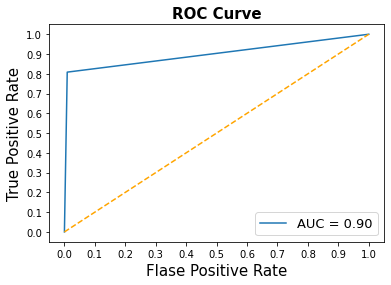

In [7]:
results = {}

accuracy, precision, recall, f1 = evaluate_model(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label = f'AUC = {roc_auc:.2f}')

plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

results["initial"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "fpr": fpr,
    "tpr": tpr,
    "roc_auc": roc_auc
}

### PCA
Next we will reduce our features via PCA. Data will also need to be standarized

In [8]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

pca = PCA(n_components=4)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
print(x_train.shape, x_test.shape)

(13423, 4) (4475, 4)


We see the feature dimensions reduce. We can now retrain our model and evaluate its performance


In [9]:
model = KNeighborsClassifier(n_jobs=-1)
model.fit(x_train, y_train)
pca_y_pred = model.predict(x_test)


Accuracy: 0.98
Precision: 0.96
Recall: 0.90
F1: 0.93


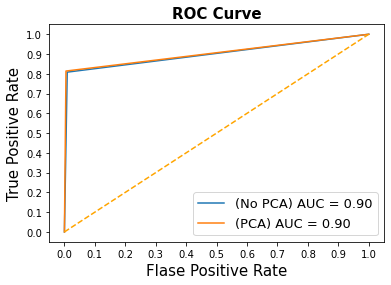

In [10]:
accuracy, precision, recall, f1 = evaluate_model(y_test, pca_y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")

pca_fpr, pca_tpr, threshold = metrics.roc_curve(y_test, pca_y_pred)
pca_roc_auc = metrics.auc(pca_fpr, pca_tpr)

plt.plot(fpr, tpr, label = f'(No PCA) AUC = {roc_auc:.2f}')
plt.plot(pca_fpr, pca_tpr, label = f'(PCA) AUC = {pca_roc_auc:.2f}')

plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

results["pca"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "fpr": fpr,
    "tpr": tpr,
    "roc_auc": roc_auc
}

### Feature importance/selection
Next step is to apply a Logistic Regression and a Random Forest to discover the most important features of our dataset
from the corresponding coefficients (feature weights) and contribution to decrease in impurity

In [11]:
x_train, x_test, y_train, y_test = train_test_split(df[["ie_mean",
                                                        "ie_standard_deviation",
                                                        "ie_excess_kurtosis",
                                                        "ie_skewness",
                                                        "dm_mean",
                                                        "dm_standard_deviation",
                                                        "dm_excess_kurtosis",
                                                        "dm_skewness",]],
                                                    df['target'],
                                                    test_size = 0.25, random_state = 0)
print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(13423, 8) (13423,) (4475, 8) (4475,)


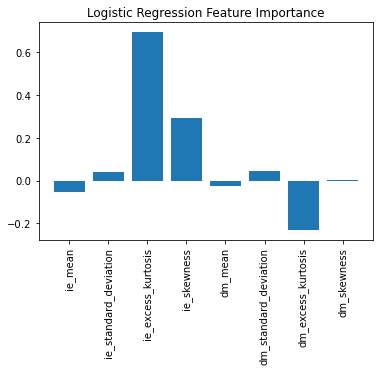

In [12]:
model = LogisticRegression(solver='saga', max_iter=10000, penalty='l2', n_jobs=-1)
model.fit(x_train, y_train)
importance = model.coef_[0]

logreg_feature_importance = {}
for idx, value in enumerate(importance):
    logreg_feature_importance[names[idx]] = value

plt.title("Logistic Regression Feature Importance")
plt.bar([label for label in logreg_feature_importance.keys()], logreg_feature_importance.values())
plt.xticks(rotation='vertical')
plt.show()

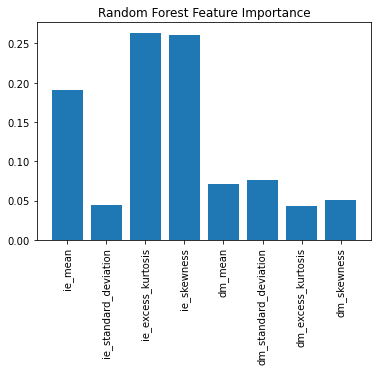

In [13]:
model = RandomForestClassifier()
model.fit(x_train, y_train)
importance = model.feature_importances_

randforest_feature_importance = {}
for idx, value in enumerate(importance):
    randforest_feature_importance[names[idx]] = value

plt.title("Random Forest Feature Importance")
plt.bar([label for label in randforest_feature_importance.keys()], randforest_feature_importance.values())
plt.xticks(rotation='vertical')
plt.show()

LogisticRegression seems to more clearly promote some of the features so we will use it as the baseline for feature
importance and selection

In [14]:
# Note: This works only on python 3.7+, before that dicts are not ordered
importance = {k: v for k, v in sorted(logreg_feature_importance.items(), key=lambda item: abs(item[1]), reverse=True)}
print("Feature importances")
pprint(importance)

Feature importances
ie_excess_kurtosis
	0.692234342533794
ie_skewness
	0.29399556183139675
dm_excess_kurtosis
	-0.23071904481995903
ie_mean
	-0.052483551959782826
dm_standard_deviation
	0.0440564439341342
ie_standard_deviation
	0.040259531558151554
dm_mean
	-0.02623651875745035
dm_skewness
	0.004221801747115312


## Performance with 4 most important features

We will begin by creating a dataframe with just our most important features

In [15]:
top_labels = list(importance.keys())[:4]
reduced_df = df[top_labels + ["target"]]
reduced_df.head()


,ie_excess_kurtosis,ie_skewness,dm_excess_kurtosis,ie_mean,target
0,-0.234571,-0.699648,7.975532,140.562500,0
1,0.465318,-0.515088,10.576487,102.507812,0
2,0.323328,1.051164,7.735822,103.015625,0
3,-0.068415,-0.636238,6.896499,136.750000,0
4,0.600866,1.123492,14.269573,88.726562,0


Re-split our data and retrain our model with the subset of features

In [16]:
x_train, x_test, y_train, y_test = train_test_split(df[top_labels], df["target"], test_size = 0.25, random_state = 0)
print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(13423, 4) (13423,) (4475, 4) (4475,)


In [17]:
model = KNeighborsClassifier(n_jobs=-1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

Accuracy: 0.98
Precision: 0.95
Recall: 0.89
F1: 0.92


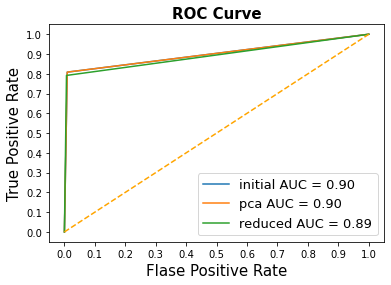

In [18]:
accuracy, precision, recall, f1 = evaluate_model(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

results["reduced"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "fpr": fpr,
    "tpr": tpr,
    "roc_auc": roc_auc
}

for experiment in results:
    plt.plot(results[experiment]["fpr"],
             results[experiment]["tpr"],
             label = f'{experiment} AUC = {results[experiment]["roc_auc"]:.2f}')

plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [19]:
pprint(results)

initial
	accuracy
		0.9760893854748603
	precision
		0.933927966604938
	recall
		0.8995494127176995
	f1
		0.9158750201385178
	fpr
		[0.         0.00923451 1.        ]
	tpr
		[0.         0.80833333 1.        ]
	roc_auc
		0.8995494127176995
pca
	accuracy
		0.9803351955307262
	precision
		0.9585095602631043
	recall
		0.9043928041042257
	f1
		0.9294015228331753
	fpr
		[0.         0.00923451 1.        ]
	tpr
		[0.         0.80833333 1.        ]
	roc_auc
		0.8995494127176995
reduced
	accuracy
		0.9769832402234637
	precision
		0.9462614741929491
	recall
		0.8924311462130416
	f1
		0.9172549076631731
	fpr
		[0.         0.00680437 1.        ]
	tpr
		[0.         0.79166667 1.        ]
	roc_auc
		0.8924311462130416


### Final "Ranking"

1. PCA
2. Initial
3. "Hand-picked" features (with Logistic Regression)